In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [7]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [29]:

def plot_predictions1(test, predicted):
    fig = go.Figure()

    # Plot the real IBM Stock Price
    fig.add_trace(go.Scatter(x=test.index, y=test['Real IBM Stock Price'], mode='lines', name='Real IBM Stock Price', line=dict(color='red')))

    # Plot the predicted IBM Stock Price
    fig.add_trace(go.Scatter(x=predicted.index, y=predicted['Predicted IBM Stock Price'], mode='lines', name='Predicted IBM Stock Price', line=dict(color='blue')))

    # Customize layout
    fig.update_layout(
        title='IBM Stock Price Prediction',
        xaxis_title='Time',
        yaxis_title='IBM Stock Price',
        legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    )

    # Show the interactive plot
    pio.show(fig)

In [9]:
dataset = pd.read_csv('/content/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [10]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

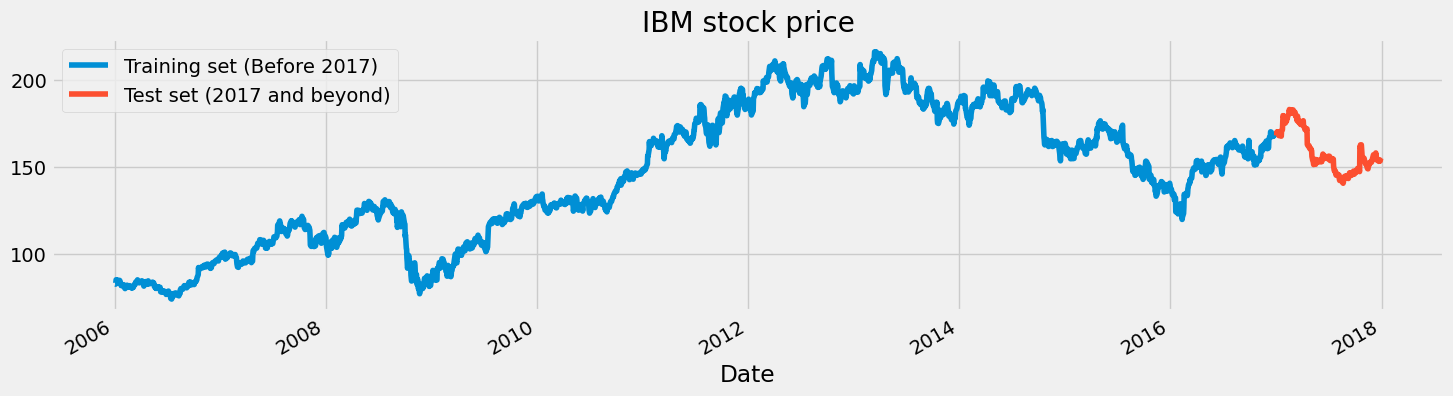

In [11]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [12]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [13]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [16]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 21s 560ms/step - loss: 0.1295
Epoch 2/50
19/19 [==============================] - 5s 244ms/step - loss: 0.0588
Epoch 3/50
19/19 [==============================] - 5s 283ms/step - loss: 0.0507
Epoch 4/50
19/19 [==============================] - 5s 259ms/step - loss: 0.0440
Epoch 5/50
19/19 [==============================] - 4s 220ms/step - loss: 0.0385
Epoch 6/50
19/19 [==============================] - 5s 276ms/step - loss: 0.0326
Epoch 7/50
19/19 [==============================] - 5s 262ms/step - loss: 0.0264
Epoch 8/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0227
Epoch 9/50
19/19 [==============================] - 5s 274ms/step - loss: 0.0189
Epoch 10/50
19/19 [==============================] - 5s 265ms/step - loss: 0.0157
Epoch 11/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0127
Epoch 12/50
19/19 [==============================] - 5s 271ms/step - loss: 0.0102
Epoch 13/50
19/19 [=====

In [17]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [22]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 135ms/step


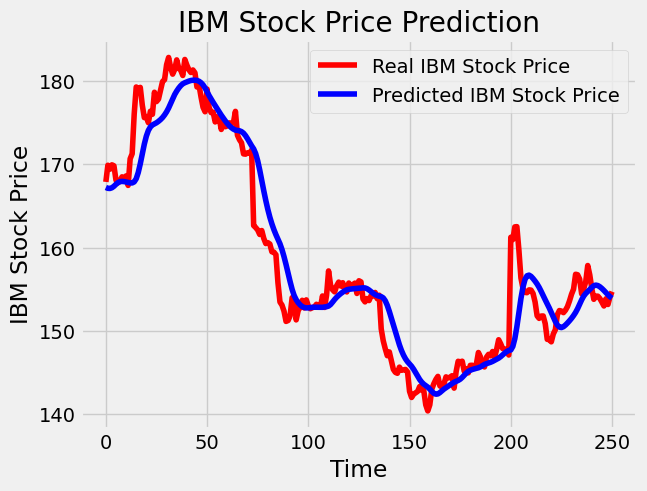

In [23]:
plot_predictions(test_set,GRU_predicted_stock_price)

In [26]:
import plotly.graph_objects as go
import plotly.io as pio

def plot_predictions(test, predicted):
    fig = go.Figure()

    # Plot the real IBM Stock Price
    fig.add_trace(go.Scatter(x=test.index, y=test['Real IBM Stock Price'], mode='lines', name='Real IBM Stock Price', line=dict(color='red')))

    # Plot the predicted IBM Stock Price
    fig.add_trace(go.Scatter(x=predicted.index, y=predicted['Predicted IBM Stock Price'], mode='lines', name='Predicted IBM Stock Price', line=dict(color='blue')))

    # Customize layout
    fig.update_layout(
        title='IBM Stock Price Prediction',
        xaxis_title='Time',
        yaxis_title='IBM Stock Price',
        legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    )

    # Show the interactive plot
    pio.show(fig)

# Example usage
# Replace 'Real IBM Stock Price' and 'Predicted IBM Stock Price' with your actual column names
# Replace test and predicted with your actual DataFrames
# plot_predictions(test, predicted)


In [24]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.3671058754711427.
